In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Load Data

In [ ]:
import zipfile
import os

zip_file_path = "./drive/MyDrive/AI Data Source/Resources_ModelTraining_CNN.zip" # Replace with the actual path
extract_path = "/content/my_dataset"  # Directory where you want to extract the files

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Successfully extracted to {extract_path}")
except FileNotFoundError:
    print(f"Error: File not found at {zip_file_path}.  Please check the path and try again.")
except zipfile.BadZipFile:
    print(f"Error: {zip_file_path} is not a valid zip file.")

# Optionally, create the extraction directory if it doesn't exist:
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print(f"Successfully extracted to {extract_path}")

Successfully extracted to /content/my_dataset
Successfully extracted to /content/my_dataset


In [ ]:
image_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
dataset_path = "/content/my_dataset/Download files/dataset"

dataset = datasets.ImageFolder(
    root=dataset_path,
    transform=image_transform
)

len(dataset)

2300

In [ ]:
dataset.classes

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [ ]:
num_classes = len(dataset.classes)
num_classes

6

In [ ]:
train_size = int(len(dataset)*0.75)
val_size = len(dataset) - train_size

train_size, val_size

(1725, 575)

In [ ]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [ ]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

In [ ]:
labels[0]

In [ ]:
images[0].shape

In [ ]:
images[0].permute(1, 2, 0).shape

torch.Size([224, 224, 3])

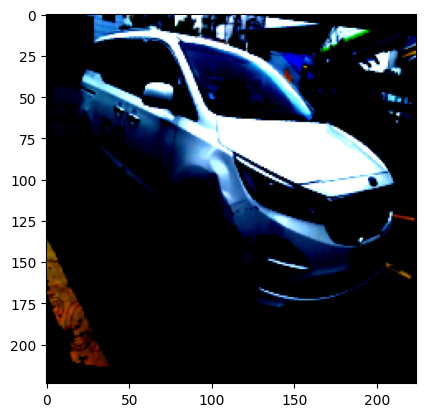

In [ ]:
plt.imshow(images[0].permute(1, 2, 0))
plt.show()

In [ ]:
# Model Training and Validation
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    start = time.time()
    for epoch in range(num_epochs):
          model.train()
          running_loss = 0.0
          for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradient
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            if (batch_num+1) % 10 == 0:
                print(f'Epoch [{epoch+1}], Batch [{batch_num+1}], Loss: {loss.item():.4f}')
                # print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_num+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

            running_loss = loss.item() * images.size(0)
            # _, predicted = torch.max(outputs.data, 1)
            # running_acc = (predicted == labels).sum().item()

          epoch_loss = running_loss / len(train_loader.dataset)
          print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

          # Validation
          model.eval()
          correct = 0
          total = 0
          all_labels = []
          all_predictions = []
          with torch.no_grad():
              for images, labels in val_loader:
                  images, labels = images.to(device), labels.to(device)
                  outputs = model(images)
                  _, predicted = torch.max(outputs.data, 1)
                  total += labels.size(0)
                  correct += (predicted == labels).sum().item()
                  all_labels.extend(labels.cpu().numpy())
                  all_predictions.extend(predicted.cpu().numpy())

              accuracy = 100 * correct / total
              print(f'Validation Accuracy: {accuracy:.2f}%')

    end = time.time()
    print(f"Execution Time: {end -  start} seconds")

    return all_labels, all_predictions

### Model-1: CNN

In [ ]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1), # output (16, 224, 224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # outout (16, 112, 112)

            nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=1), # output (32, 112, 112)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # output (32, 56, 56)

            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1), # output (64, 56, 56)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # output (64, 28, 28)

            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
            # nn.Linear(512, 256),
            # nn.ReLU(),
            # nn.Linear(256, num_classes)
        )

    def forward(self, xb):
        return self.network(xb)

In [ ]:
num_classes = len(dataset.classes)

model = CarClassifierCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
all_labels, all_predictions = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=2)

Epoch [1], Batch [10], Loss: 1.7801
Epoch [1], Batch [20], Loss: 1.7509
Epoch [1], Batch [30], Loss: 1.6262
Epoch [1], Batch [40], Loss: 1.6166
Epoch [1], Batch [50], Loss: 1.5022
Epoch 1/2, Loss: 0.0204
Validation Accuracy: 48.52%
Epoch [2], Batch [10], Loss: 1.0918
Epoch [2], Batch [20], Loss: 1.1617
Epoch [2], Batch [30], Loss: 1.1270
Epoch [2], Batch [40], Loss: 1.2150
Epoch [2], Batch [50], Loss: 0.9682
Epoch 2/2, Loss: 0.0167
Validation Accuracy: 52.52%
Execution Time: 693.0647413730621 seconds


### Model-2: CNN with Regularization

In [ ]:
class CarClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1), # output (16, 224, 224)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # outout (16, 112, 112)

            nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=1), # output (32, 112, 112)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # output (32, 56, 56)

            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1), # output (64, 56, 56)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # output (64, 28, 28)

            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
            # nn.Linear(512, 256),
            # nn.ReLU(),
            # nn.Linear(256, num_classes)
        )

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = CarClassifierCNNWithRegularization(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=2)

Epoch [1], Batch [10], Loss: 15.9966
Epoch [1], Batch [20], Loss: 4.9436
Epoch [1], Batch [30], Loss: 1.5896
Epoch [1], Batch [40], Loss: 1.5704
Epoch [1], Batch [50], Loss: 1.5632
Epoch 1/2, Loss: 0.0241
Validation Accuracy: 41.39%
Epoch [2], Batch [10], Loss: 1.4612
Epoch [2], Batch [20], Loss: 1.4032
Epoch [2], Batch [30], Loss: 1.4346
Epoch [2], Batch [40], Loss: 1.3305
Epoch [2], Batch [50], Loss: 1.3788
Epoch 2/2, Loss: 0.0318
Validation Accuracy: 43.65%
Execution Time: 703.1768805980682 seconds


([np.int64(2),
  np.int64(1),
  np.int64(2),
  np.int64(2),
  np.int64(1),
  np.int64(4),
  np.int64(4),
  np.int64(2),
  np.int64(4),
  np.int64(2),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(5),
  np.int64(2),
  np.int64(1),
  np.int64(2),
  np.int64(4),
  np.int64(0),
  np.int64(4),
  np.int64(2),
  np.int64(0),
  np.int64(5),
  np.int64(0),
  np.int64(5),
  np.int64(2),
  np.int64(4),
  np.int64(1),
  np.int64(4),
  np.int64(0),
  np.int64(2),
  np.int64(2),
  np.int64(2),
  np.int64(2),
  np.int64(2),
  np.int64(5),
  np.int64(5),
  np.int64(1),
  np.int64(2),
  np.int64(1),
  np.int64(5),
  np.int64(2),
  np.int64(4),
  np.int64(2),
  np.int64(3),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(3),
  np.int64(0),
  np.int64(1),
  np.int64(2),
  np.int64(4),
  np.int64(2),
  np.int64(0),
  np.int64(4),
  np.int64(3),
  np.int64(5),
  np.int64(3),
  np.int64(0),
  np.int64(2),
  np.int64(2),
  np.int64(5),
  np.int64(4),
  np.int64

### Model-3: Transfer Learning with EfficientNet

In [ ]:
model = models.efficientnet_b0(weights="DEFAULT")
in_features = model.classifier[1].in_features
in_features

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 109MB/s] 


1280

In [ ]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')

        for param in self.model.parameters():
            param.requires_grad = False

        in_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, xb):
        return self.model(xb)

In [ ]:
model = CarClassifierEfficientNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p:p.requires_grad, model.parameters()), lr=0.001)

all_labels, all_predictions = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=2)

KeyboardInterrupt: 

### Model-4: Transfer Learning with ResNet

In [ ]:
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')

        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze layer 4 and fc layer
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate, inplace=True),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, xb):
        return self.model(xb)

In [ ]:
model = CarClassifierResNet(num_classes, 0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p:p.requires_grad, model.parameters()), lr=0.005)

all_labels, all_predictions = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 141MB/s]


Epoch [1], Batch [10], Loss: 1.2564
Epoch [1], Batch [20], Loss: 1.1022
Epoch [1], Batch [30], Loss: 0.8571
Epoch [1], Batch [40], Loss: 0.7376
Epoch [1], Batch [50], Loss: 1.0267
Epoch 1/10, Loss: 0.0090
Validation Accuracy: 58.61%
Epoch [2], Batch [10], Loss: 0.4677
Epoch [2], Batch [20], Loss: 0.4583
Epoch [2], Batch [30], Loss: 0.5286
Epoch [2], Batch [40], Loss: 0.5740
Epoch [2], Batch [50], Loss: 0.3768
Epoch 2/10, Loss: 0.0100
Validation Accuracy: 77.04%
Epoch [3], Batch [10], Loss: 0.3709
Epoch [3], Batch [20], Loss: 0.4237
Epoch [3], Batch [30], Loss: 0.3126
Epoch [3], Batch [40], Loss: 0.7285
Epoch [3], Batch [50], Loss: 0.3289
Epoch 3/10, Loss: 0.0033
Validation Accuracy: 75.30%
Epoch [4], Batch [10], Loss: 0.2024
Epoch [4], Batch [20], Loss: 0.1851
Epoch [4], Batch [30], Loss: 0.3634
Epoch [4], Batch [40], Loss: 0.1529
Epoch [4], Batch [50], Loss: 0.3386
Epoch 4/10, Loss: 0.0016
Validation Accuracy: 82.61%
Epoch [5], Batch [10], Loss: 0.3137
Epoch [5], Batch [20], Loss: 0.0

([np.int64(1),
  np.int64(2),
  np.int64(3),
  np.int64(0),
  np.int64(5),
  np.int64(2),
  np.int64(5),
  np.int64(1),
  np.int64(4),
  np.int64(1),
  np.int64(2),
  np.int64(4),
  np.int64(5),
  np.int64(1),
  np.int64(0),
  np.int64(4),
  np.int64(1),
  np.int64(2),
  np.int64(2),
  np.int64(1),
  np.int64(2),
  np.int64(4),
  np.int64(5),
  np.int64(0),
  np.int64(0),
  np.int64(2),
  np.int64(5),
  np.int64(3),
  np.int64(3),
  np.int64(0),
  np.int64(5),
  np.int64(2),
  np.int64(3),
  np.int64(3),
  np.int64(1),
  np.int64(4),
  np.int64(2),
  np.int64(2),
  np.int64(1),
  np.int64(2),
  np.int64(4),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(5),
  np.int64(2),
  np.int64(4),
  np.int64(1),
  np.int64(1),
  np.int64(4),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(2),
  np.int64(1),
  np.int64(2),
  np.int64(0),
  np.int64(0),
  np.int64(5),
  np.int64(2),
  np.int64(4),
  np.int64(0),
  np.int64(5),
  np.int64(0),
  np.int64(4),
  np.int64

In [ ]:
torch.save(model.state_dict(), 'resnet_model.pth')

### Model Evaluation using Confusion Matrix and  Classification Report

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

report = classification_report(all_labels, all_predictions, target_names=dataset.classes)
print(report)

NameError: name 'all_labels' is not defined

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dataset.classes)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

NameError: name 'all_labels' is not defined

### Model Tuning and Hyperparameter Tuning using Optuna

In [ ]:
class CarClassifierResNetMTHT(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')

        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze layer 4 and fc layer
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        self.model.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate, inplace=True),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, xb):
        return self.model(xb)

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 17.4 MB/s eta 0:00:00


In [ ]:
import optuna

# define objective function for Optuna
def objective(trial):
    # define hyperparameters to be tuned
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.7)

    # Load the Model
    model = CarClassifierResNetMTHT(num_classes, dropout_rate=dropout_rate).to(device)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p:p.requires_grad, model.parameters()), lr=lr)

    # Train the model loop (using feawer for faster hyperparameter tuning)
    epochs = 2
    start = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradient
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # Validation loop
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total

        # Report intermidiate result to Optuna
        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.expectation.TrialPruned()